In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt


# # Define the directory containing the images
# #test_image = "BPS-Microscopy/DAPI_MASK_images"
image_dir = "BPS-Microscopy/train"

# Load the metadata from the Excel file
# metadata_path = 'BPS-Microscopy/DAPI_MASK_images/meta_DAPI_MASK.csv'
metadata_path = 'BPS-Microscopy/train/meta.csv'
metadata = pd.read_csv(metadata_path)

# Display the first few rows of the metadata
# print(metadata.head())

# Add the full path to the filenames in the metadata
metadata['filepath'] = metadata['filename'].apply(lambda x: os.path.join(image_dir, x))

# Filter only tif
metadata = metadata[metadata['filename'].str.endswith('.tif')]

# Display the first few rows of the updated metadata
# metadata.head()


# Load the list of outlier file paths
outliers_file = "outliers_list.txt"  # Path to the saved outliers list
with open(outliers_file, "r") as f:
    outlier_filepaths = set(line.strip() for line in f)

print(f"Number of outliers to remove: {len(outlier_filepaths)}")

# Remove outliers from the metadata
filtered_metadata = metadata[~metadata['filepath'].isin(outlier_filepaths)]

# Print results
print(f"Original metadata size: {len(metadata)}")
print(f"Filtered metadata size: {len(filtered_metadata)}")

metadata = filtered_metadata

2024-11-24 17:21:38.847659: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732497698.862585 1784359 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732497698.867606 1784359 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 17:21:38.885953: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of outliers to remove: 27
Original metadata size: 77177
Filtered metadata size: 77150


In [ ]:
from phasepack.phasecong import phasecong
from skimage.measure import shannon_entropy
from skimage.filters import sobel, laplace
from skimage.feature import graycomatrix, graycoprops
from skimage import io
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pickle

def extract_features(image, config):
    """
    Dynamically extracts features based on the configuration.
    Features:
    - Mean Phase Congruency (MPC)
    - Entropy of Phase Congruency (EPC)
    - Entropy of the Image (EDIS)
    - Mean Gradient Magnitude of the Image (MGDIS)
    - Texture Features (GLCM Contrast, Homogeneity)
    - Edge Sharpness (Variance of Laplacian)

    Parameters:
    - image: np.array, input grayscale image
    - config: dict, configuration for which features to extract

    Returns:
    - features: list of feature values
    """
    features = []

    # Compute Phase Congruency features if enabled
    if config.get("include_mpc", True):
        pc_image, *_ = phasecong(image)
        mpc = np.mean(pc_image)
        epc = shannon_entropy(pc_image)
        features.extend([mpc, epc])

    # Compute Image Entropy if enabled
    if config.get("include_edis", True):
        edis = shannon_entropy(image)
        features.append(edis)

    # Compute Mean Gradient Magnitude if enabled
    if config.get("include_mgdis", True):
        gradient_image = sobel(image)
        mgdis = np.mean(gradient_image)
        features.append(mgdis)

    # Compute Texture Features (GLCM) if enabled
    if config.get("include_texture", True):
        glcm = graycomatrix(image.astype(np.uint8), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        features.extend([contrast, homogeneity])

    # Compute Edge Sharpness (Variance of Laplacian) if enabled
    if config.get("include_sharpness", True):
        laplacian_var = np.var(laplace(image))
        features.append(laplacian_var)

    return features


def prepare_feature_dataset(metadata, config):
    """
    Extract features and labels for a given dataset dynamically based on config.
    """
    features = []
    labels = []
    for _, row in metadata.iterrows():
        image_path = row['filepath']  # Replace with the correct column name for image paths
        try:
            # Load the image
            image = io.imread(image_path, as_gray=True)

            # # Clip pixel values between 400 and 4000
            # image = np.clip(image, 400, 4000)

            # Extract features dynamically
            feature = extract_features(image, config)
            features.append(feature)

            # Append the label
            labels.append(row['dose_Gy'])  # Replace 'dose' with your target column name
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
    return np.array(features), np.array(labels)


def load_or_prepare_features(metadata, hr_post_exposure, particle_type, config):
    filtered_metadata = metadata[
        (metadata['hr_post_exposure'] == hr_post_exposure) &
        (metadata['particle_type'] == particle_type)
    ]
    processed_dir = "processed_features"

    # Define filenames dynamically based on filtering criteria
    train_path = os.path.join(processed_dir, f"train_hr{hr_post_exposure}_particle{particle_type}.pkl")
    val_path = os.path.join(processed_dir, f"val_hr{hr_post_exposure}_particle{particle_type}.pkl")
    test_path = os.path.join(processed_dir, f"test_hr{hr_post_exposure}_particle{particle_type}.pkl")

    if os.path.exists(train_path) and os.path.exists(val_path) and os.path.exists(test_path):
        print("Loading processed datasets and metadata...")
        with open(train_path, "rb") as f:
            X_train, y_train, train_metadata = pickle.load(f)
        with open(val_path, "rb") as f:
            X_val, y_val, val_metadata = pickle.load(f)
        with open(test_path, "rb") as f:
            X_test, y_test, test_metadata = pickle.load(f)
        print(f"Feature shape (X_train): {X_train.shape}")
        print(f"Feature shape (X_val): {X_val.shape}")
        print(f"Feature shape (X_test): {X_test.shape}")
    else:
        print("Processed datasets not found. Calculating features...")

        # Shuffle and split metadata
        shuffled_metadata = filtered_metadata.sample(frac=1, random_state=42).reset_index(drop=True)
        train_size = int(len(shuffled_metadata) * 0.7)
        val_size = int(len(shuffled_metadata) * 0.2)

        train_metadata = shuffled_metadata[:train_size]
        val_metadata = shuffled_metadata[train_size:train_size + val_size]
        test_metadata = shuffled_metadata[train_size + val_size:]

        # Extract features and labels dynamically
        X_train, y_train = prepare_feature_dataset(train_metadata, config)
        X_val, y_val = prepare_feature_dataset(val_metadata, config)
        X_test, y_test = prepare_feature_dataset(test_metadata, config)

        # Normalize features
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

        # Save datasets with metadata
        os.makedirs(processed_dir, exist_ok=True)
        with open(train_path, "wb") as f:
            pickle.dump((X_train, y_train, train_metadata), f)
        with open(val_path, "wb") as f:
            pickle.dump((X_val, y_val, val_metadata), f)
        with open(test_path, "wb") as f:
            pickle.dump((X_test, y_test, test_metadata), f)


        print(f"Feature shape (X_train): {X_train.shape}")
        print(f"Feature shape (X_val): {X_val.shape}")
        print(f"Feature shape (X_test): {X_test.shape}")



    return X_train, y_train, X_val, y_val, X_test, y_test, train_metadata, val_metadata, test_metadata


# Define filtering criteria and feature configuration
hr_post_exposure = 4
particle_type = 'X-ray'

feature_config = {
    "include_mpc": True,
    "include_edis": False,
    "include_mgdis": True,
    "include_texture": True,
    "include_sharpness": True,  # Example of excluding sharpness
}

# Pass criteria and config explicitly to the function
X_train, y_train, X_val, y_val, X_test, y_test, train_metadata, val_metadata, test_metadata = load_or_prepare_features(
    metadata, hr_post_exposure, particle_type, feature_config
)

print(f"Filtering Criteria - hr_post_exposure: {hr_post_exposure}, particle_type: {particle_type}")
print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")


Loading processed datasets and metadata...
Feature shape (X_train): (9766, 7)
Feature shape (X_val): (2790, 7)
Feature shape (X_test): (1396, 7)
Filtering Criteria - hr_post_exposure: 4, particle_type: X-ray
Train size: 9766, Validation size: 2790, Test size: 1396


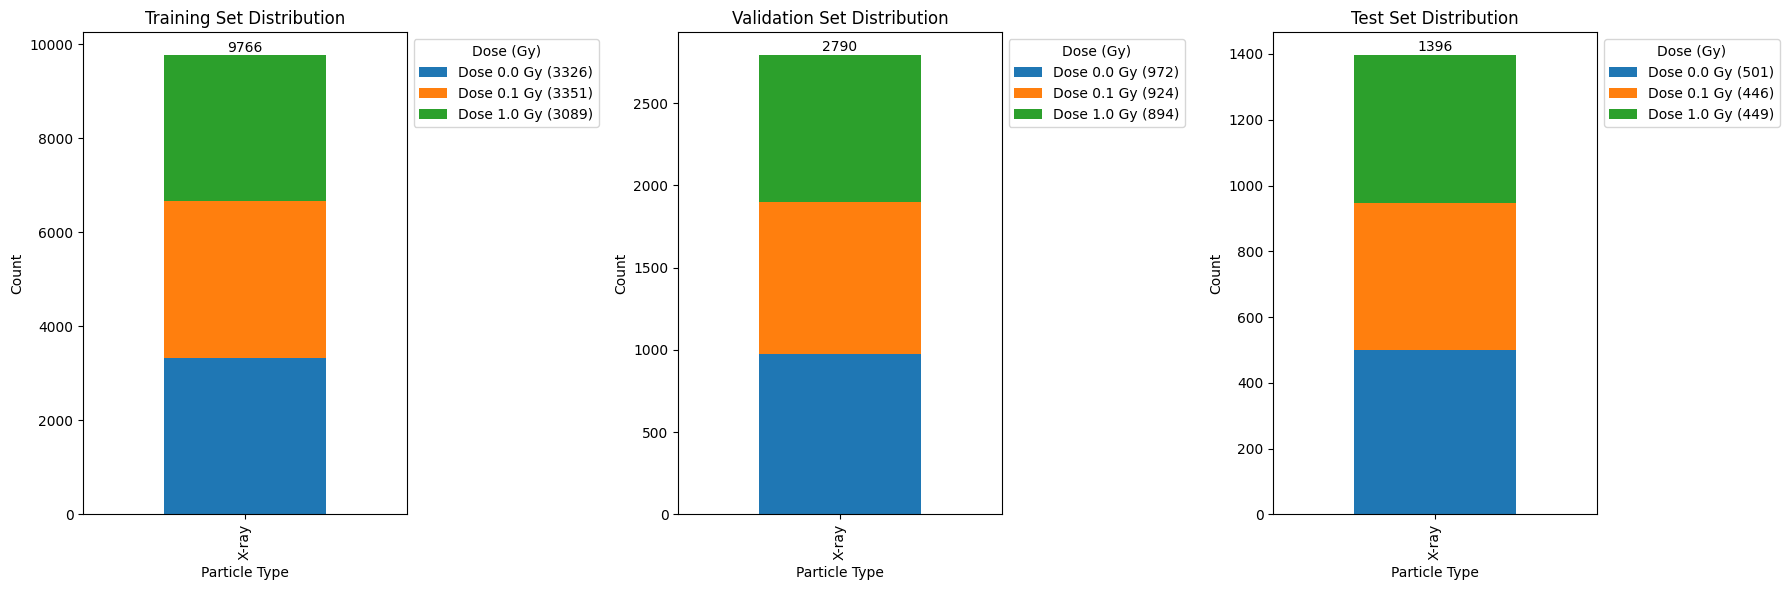

In [3]:
# Check set split

# Function to add total count annotations for each group
def annotate_group_totals(ax, data):
    for i, patch in enumerate(ax.patches):
        if i % len(data.columns) == 0:  # Add annotation only for the first bar of each group
            x = patch.get_x() + patch.get_width() / 2
            total = data.iloc[i // len(data.columns)].sum()
            ax.annotate(f'{int(total)}', (x, total + 5), ha='center', va='bottom', fontsize=10, color='black')

# Function to create legend labels with counts
def create_legend_labels(data):
    labels = []
    for dose in data.columns:
        count = data[dose].sum()
        labels.append(f"Dose {dose} Gy ({int(count)})")
    return labels

# Plot all sets: training, validation, and test
plt.figure(figsize=(18, 6))

# Training set plot
plt.subplot(1, 3, 1)
train_counts = train_metadata.groupby(['particle_type', 'dose_Gy']).size().unstack().fillna(0)
train_ax = train_counts.plot(kind='bar', stacked=True, ax=plt.gca(), legend=False)
annotate_group_totals(train_ax, train_counts)
plt.title('Training Set Distribution')
plt.xlabel('Particle Type')
plt.ylabel('Count')

# Add legend with counts for training set
train_labels = create_legend_labels(train_counts)
plt.legend(train_labels, title="Dose (Gy)", bbox_to_anchor=(1.0, 1.0), loc='upper left')

# Validation set plot
plt.subplot(1, 3, 2)
val_counts = val_metadata.groupby(['particle_type', 'dose_Gy']).size().unstack().fillna(0)
val_ax = val_counts.plot(kind='bar', stacked=True, ax=plt.gca(), legend=False)
annotate_group_totals(val_ax, val_counts)
plt.title('Validation Set Distribution')
plt.xlabel('Particle Type')
plt.ylabel('Count')

# Add legend with counts for validation set
val_labels = create_legend_labels(val_counts)
plt.legend(val_labels, title="Dose (Gy)", bbox_to_anchor=(1.0, 1.0), loc='upper left')

# Test set plot
plt.subplot(1, 3, 3)
test_counts = test_metadata.groupby(['particle_type', 'dose_Gy']).size().unstack().fillna(0)
test_ax = test_counts.plot(kind='bar', stacked=True, ax=plt.gca(), legend=False)
annotate_group_totals(test_ax, test_counts)
plt.title('Test Set Distribution')
plt.xlabel('Particle Type')
plt.ylabel('Count')

# Add legend with counts for test set
test_labels = create_legend_labels(test_counts)
plt.legend(test_labels, title="Dose (Gy)", bbox_to_anchor=(1.0, 1.0), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: walt_. Use `wandb login --relogin` to force relogin


I0000 00:00:1732497703.172399 1784359 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21770 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:33:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,561 (10.00 KB)

 Trainable params: 2,561 (10.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


I0000 00:00:1732497704.966383 1784524 service.cc:148] XLA service 0x7f87d000b0c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732497704.966742 1784524 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-11-24 17:21:44.992132: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732497705.066421 1784524 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1732497705.791320 1784524 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


611/611 - 4s - 6ms/step - loss: 0.2944 - mae: 0.2944 - val_loss: 0.2785 - val_mae: 0.2785
Epoch 2/20
611/611 - 1s - 2ms/step - loss: 0.2738 - mae: 0.2738 - val_loss: 0.2664 - val_mae: 0.2664
Epoch 3/20
611/611 - 1s - 2ms/step - loss: 0.2401 - mae: 0.2401 - val_loss: 0.2068 - val_mae: 0.2068
Epoch 4/20
611/611 - 1s - 2ms/step - loss: 0.2014 - mae: 0.2014 - val_loss: 0.2033 - val_mae: 0.2033
Epoch 5/20
611/611 - 1s - 2ms/step - loss: 0.1945 - mae: 0.1945 - val_loss: 0.2105 - val_mae: 0.2105
Epoch 6/20
611/611 - 1s - 2ms/step - loss: 0.1879 - mae: 0.1879 - val_loss: 0.1863 - val_mae: 0.1863
Epoch 7/20
611/611 - 1s - 2ms/step - loss: 0.1867 - mae: 0.1867 - val_loss: 0.1814 - val_mae: 0.1814
Epoch 8/20
611/611 - 1s - 2ms/step - loss: 0.1851 - mae: 0.1851 - val_loss: 0.1802 - val_mae: 0.1802
Epoch 9/20
611/611 - 1s - 2ms/step - loss: 0.1876 - mae: 0.1876 - val_loss: 0.1924 - val_mae: 0.1924
Epoch 10/20
611/611 - 1s - 2ms/step - loss: 0.1844 - mae: 0.1844 - val_loss: 0.1833 - val_mae: 0.1833


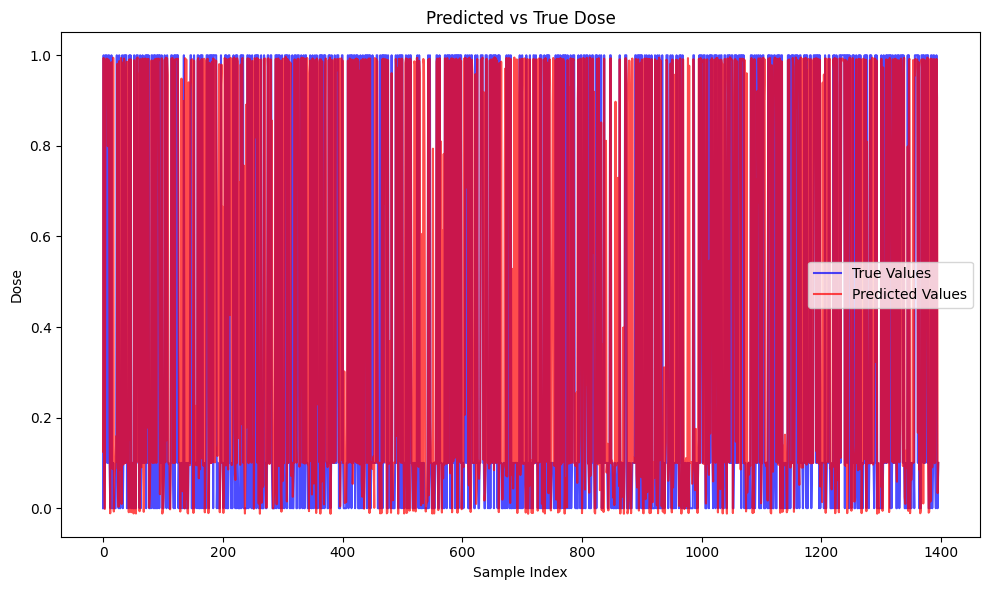

In [4]:
# Import required libraries
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbEvalCallback
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt


# Initialize W&B with corrected parameters
wandb.init(
    project="dose-prediction",
    config={
        "input_dim": 7,  # Correct input_dim will be dynamically calculated
        "batch_size": 16,
        "learning_rate": 0.005,
        "epochs": 20,
        "loss_function": "mean_absolute_error",
        "optimizer": "Adam",
        "activation_function": "tanh",
        "include_mpc": True,
        "include_edis": False,
        "include_mgdis": True,
        "include_texture": True,
        "include_sharpness": True,
    },
    tags=["xray_4hr", "grnn_like", "noclip", "nooutliers"]
)

# Dynamically calculate input_dim based on feature flags
def calculate_input_dim(config):
    feature_count = 0
    if config.get('include_mpc', True):
        feature_count += 2  # MPC and EPC
    if config.get('include_edis', False):
        feature_count += 1  # EDIS
    if config.get('include_mgdis', True):
        feature_count += 1  # MGDIS
    if config.get('include_texture', True):
        feature_count += 2  # Contrast and Homogeneity
    if config.get('include_sharpness', True):
        feature_count += 1  # Sharpness
    return feature_count

# Subset features dynamically based on active config
def subset_features(X, config):
    selected_features = []
    feature_index = 0

    if config.get('include_mpc', True):
        selected_features.extend([feature_index, feature_index + 1])
        feature_index += 2

    if config.get('include_edis', False):
        selected_features.append(feature_index)
        feature_index += 1

    if config.get('include_mgdis', True):
        selected_features.append(feature_index)
        feature_index += 1

    if config.get('include_texture', True):
        selected_features.extend([feature_index, feature_index + 1])
        feature_index += 2

    if config.get('include_sharpness', True):
        selected_features.append(feature_index)
        feature_index += 1

    return X[:, selected_features]

# Define GRNN-like network
def grnn(input_dim, learning_rate, activation_function, loss_function):
    inputs = layers.Input(shape=(input_dim,))
    pattern_layer = layers.Dense(64, activation=activation_function)(inputs)
    summation_layer = layers.Dense(32, activation=activation_function)(pattern_layer)
    outputs = layers.Dense(1, activation='linear')(summation_layer)
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=loss_function,
        metrics=['mae']
    )
    return model

# Dynamically subset the pre-calculated feature arrays
config = wandb.config
input_dim = calculate_input_dim(config)
X_train_subset = subset_features(X_train, config)
X_val_subset = subset_features(X_val, config)
X_test_subset = subset_features(X_test, config)

# Validate that the feature dimensions align with the calculated input_dim
assert X_train_subset.shape[1] == input_dim, "Mismatch in X_train dimensions"
assert X_val_subset.shape[1] == input_dim, "Mismatch in X_val dimensions"
assert X_test_subset.shape[1] == input_dim, "Mismatch in X_test dimensions"

# Build and compile the model dynamically
model = grnn(
    input_dim=input_dim,
    learning_rate=config.learning_rate,
    activation_function=config.activation_function,
    loss_function=config.loss_function
)

# Define callbacks
metrics_logger = WandbMetricsLogger(log_freq="epoch")
model_checkpoint = WandbModelCheckpoint(filepath="model-checkpoints/model.epoch{epoch:02d}.keras")

# Model summary
wandb.log({"Model Summary": model.summary()})

# Define the custom evaluation callback for GRNN
class DosePredictionEval(WandbEvalCallback):
    def __init__(self, validation_data, data_table_columns, pred_table_columns):
        """
        Custom evaluation callback for GRNN.

        Parameters:
        - validation_data: Tuple of (features, labels) for validation
        - data_table_columns: List of columns for the ground truth table
        - pred_table_columns: List of columns for the prediction table
        """
        super().__init__(data_table_columns, pred_table_columns)
        self.features, self.labels = validation_data  # Validation feature vectors and labels

    def add_ground_truth(self, logs=None):
        """
        Log the ground truth data.
        """
        for idx, (feature, label) in enumerate(zip(self.features, self.labels)):
            self.data_table.add_data(idx, feature.tolist(), label)

    def add_model_predictions(self, epoch, logs=None):
        """
        Log model predictions.
        """
        preds = self.model.predict(self.features)
        for idx, (feature, label, pred) in enumerate(zip(self.features, self.labels, preds)):
            self.pred_table.add_data(
                epoch, idx, feature.tolist(), label, pred[0]
            )


# Prepare a batch for evaluation
# Use a small subset of the validation dataset for logging
val_features, val_labels = X_val[:10], y_val[:10]

# Define the evaluation callback
eval_callback = DosePredictionEval(
    validation_data=(val_features, val_labels),
    data_table_columns=["index", "features", "true dose"],
    pred_table_columns=["epoch", "index", "features", "true dose", "predicted dose"],
)


# Train the model
history = model.fit(
    X_train_subset, y_train,
    validation_data=(X_val_subset, y_val),
    epochs=config.epochs,
    batch_size=config.batch_size,
    verbose=2,
    callbacks=[metrics_logger, model_checkpoint],
)

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test_subset, y_test, verbose=0)
predicted_doses = model.predict(X_test_subset).flatten()

# Calculate additional metrics
test_r2 = r2_score(y_test, predicted_doses)
test_mse = mean_squared_error(y_test, predicted_doses)
test_abs_errors = np.abs(y_test - predicted_doses)
max_abs_error = np.max(test_abs_errors)

# Log metrics
wandb.log({
    "Test Loss": test_loss,
    "Test MAE": test_mae,
    "Test R²": test_r2,
    "Test MSE": test_mse,
    "Max Absolute Error (Test)": max_abs_error
})

# Plot and log predictions vs true values
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label="True Values", color="blue", alpha=0.7)
plt.plot(range(len(y_test)), predicted_doses, label="Predicted Values", color="red", alpha=0.7)
plt.title("Predicted vs True Dose")
plt.xlabel("Sample Index")
plt.ylabel("Dose")
plt.legend()
plt.tight_layout()
plt.savefig("predicted_vs_true.png")
wandb.log({"Predicted vs True Dose Plot": wandb.Image("predicted_vs_true.png")})

# Finish the run
# wandb.finish()


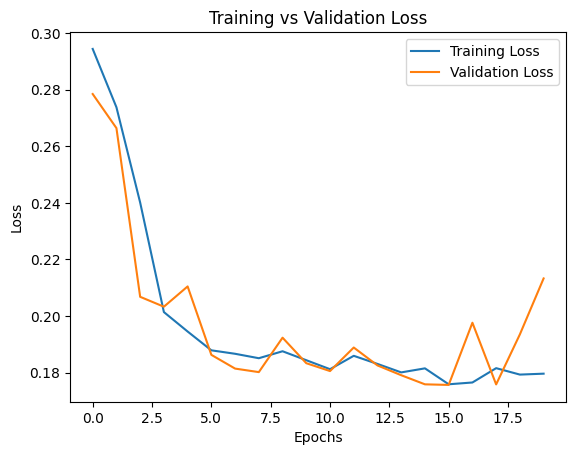

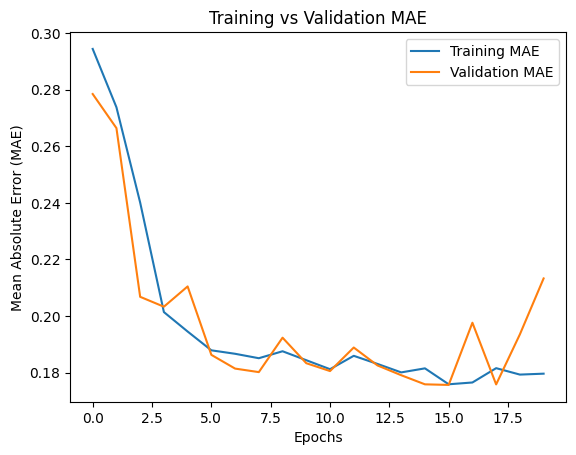

In [5]:
# Plot loss curves
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

# Save and log loss plot
plt.savefig("loss_curve.png")
wandb.log({"Loss Curve": wandb.Image("loss_curve.png")})
plt.close()

# Plot MAE curves
plt.figure()
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.title('Training vs Validation MAE')
plt.show()

# Save and log MAE plot
plt.savefig("mae_curve.png")
wandb.log({"MAE Curve": wandb.Image("mae_curve.png")})
plt.close()


In [6]:
# Dynamically subset the pre-calculated feature arrays
X_test_subset = subset_features(X_test, wandb.config)

# Dynamically calculate input_dim after subsetting
actual_input_dim = X_test_subset.shape[1]
wandb.config.update({"input_dim": actual_input_dim}, allow_val_change=True)

# Log the shapes and updated input_dim for debugging
print(f"X_test shape (subset): {X_test_subset.shape}")
print(f"Model input shape: {model.input_shape}")
print(f"Updated wandb.config.input_dim: {wandb.config.input_dim}")

# Validate that the feature array dimensions match the updated input_dim
assert X_test_subset.shape[1] == wandb.config.input_dim, (
    f"X_test has {X_test_subset.shape[1]} features, but model expects {wandb.config.input_dim}."
)

# Evaluate the model with subsetted test array
test_results = model.evaluate(X_test_subset, y_test, verbose=0)

# Predict using the model
predicted_doses = model.predict(X_test_subset).flatten()

# Log metrics to W&B
true_doses = test_metadata['dose_Gy'].values
wandb.log({
    "Test Loss": test_results[0],
    "Test MAE": test_results[1],
    "R²": r2_score(true_doses, predicted_doses)
})


X_test shape (subset): (1396, 6)
Model input shape: (None, 6)
Updated wandb.config.input_dim: 6
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [7]:
# Import required libraries
from sklearn.metrics import r2_score, mean_absolute_error
import pandas as pd
import cv2

# Create a comparison metric (absolute error)
absolute_errors = abs(true_doses - predicted_doses)

# Create a comparison table
comparison_table = pd.DataFrame({
    "Filename": test_metadata["filepath"].values,
    "Actual Dose": true_doses,
    "Predicted Dose": predicted_doses,
    "Absolute Error": absolute_errors
})

# Log sorted comparison table to W&B
sorted_comparison_table = comparison_table.sort_values(by="Absolute Error", ascending=True).reset_index(drop=True)
wandb_table = wandb.Table(dataframe=sorted_comparison_table)
wandb.log({"Comparison Table": wandb_table})

# Log best and worst examples
best_examples = sorted_comparison_table.head(5)
worst_examples = sorted_comparison_table.tail(5)

for _, row in best_examples.iterrows():
    image = cv2.imread(row['Filename'], cv2.IMREAD_GRAYSCALE)
    wandb.log({
        "Best Predictions": wandb.Image(image, caption=f"Actual: {row['Actual Dose']}, Predicted: {row['Predicted Dose']}")
    })

for _, row in worst_examples.iterrows():
    image = cv2.imread(row['Filename'], cv2.IMREAD_GRAYSCALE)
    wandb.log({
        "Worst Predictions": wandb.Image(image, caption=f"Actual: {row['Actual Dose']}, Predicted: {row['Predicted Dose']}")
    })

# Print overall MAE
overall_mae = mean_absolute_error(true_doses, predicted_doses)
print(f"Overall MAE: {overall_mae}")


Overall MAE: 0.20153978844640247


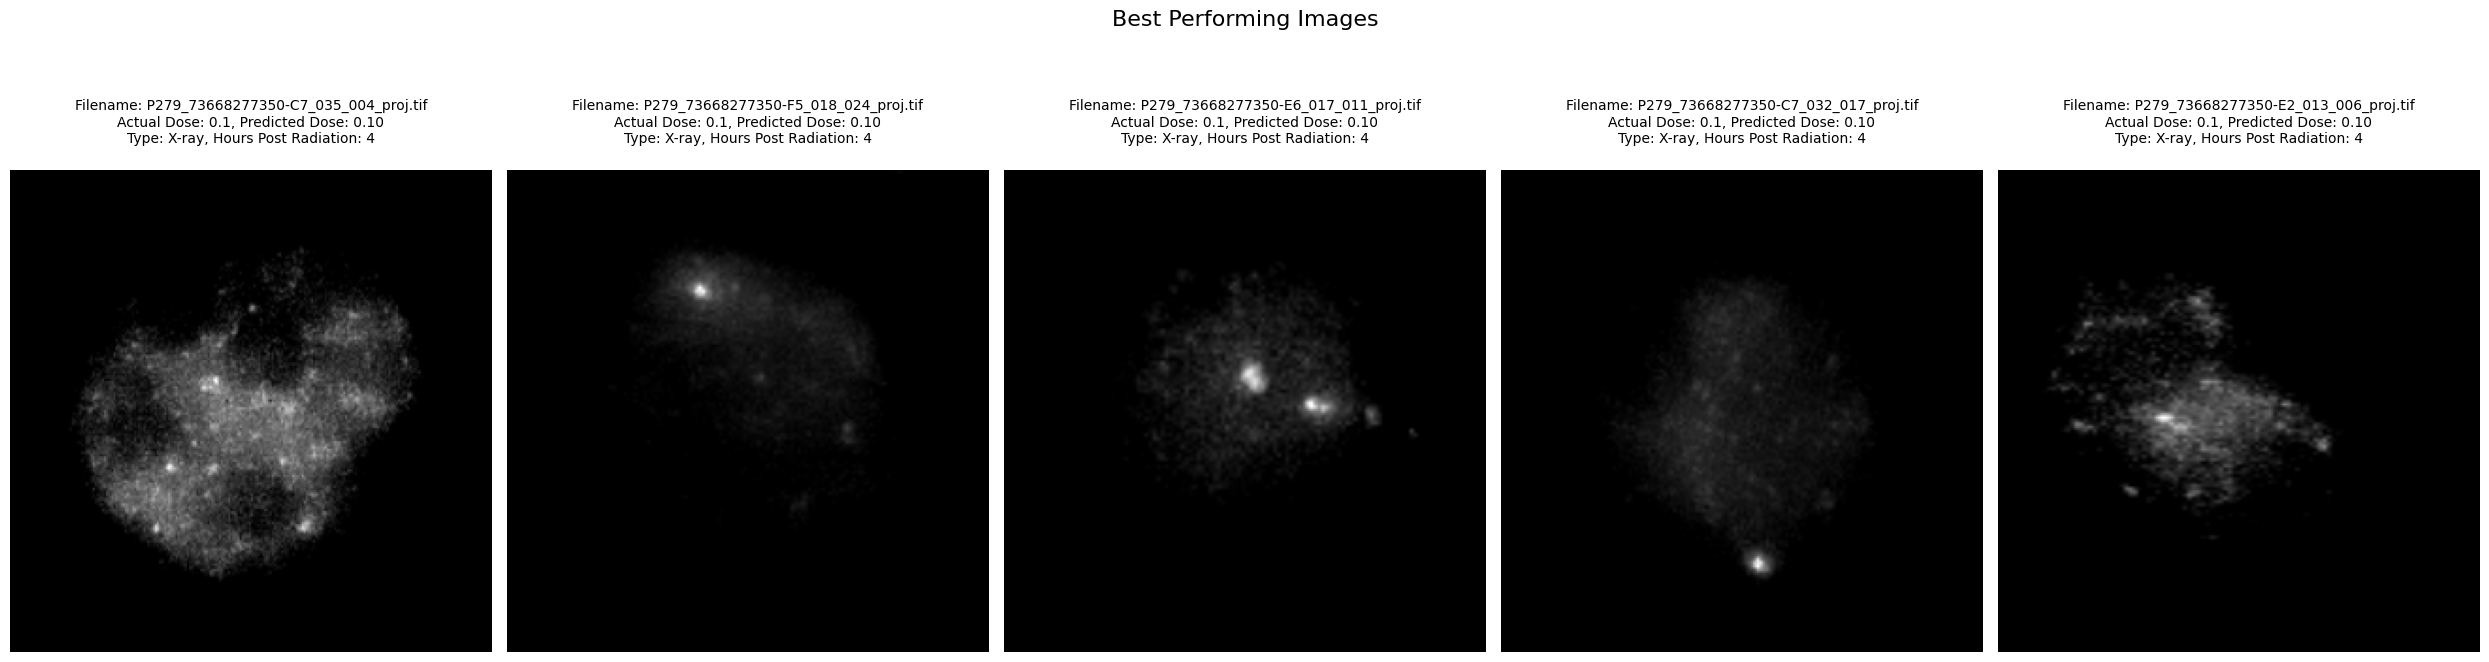

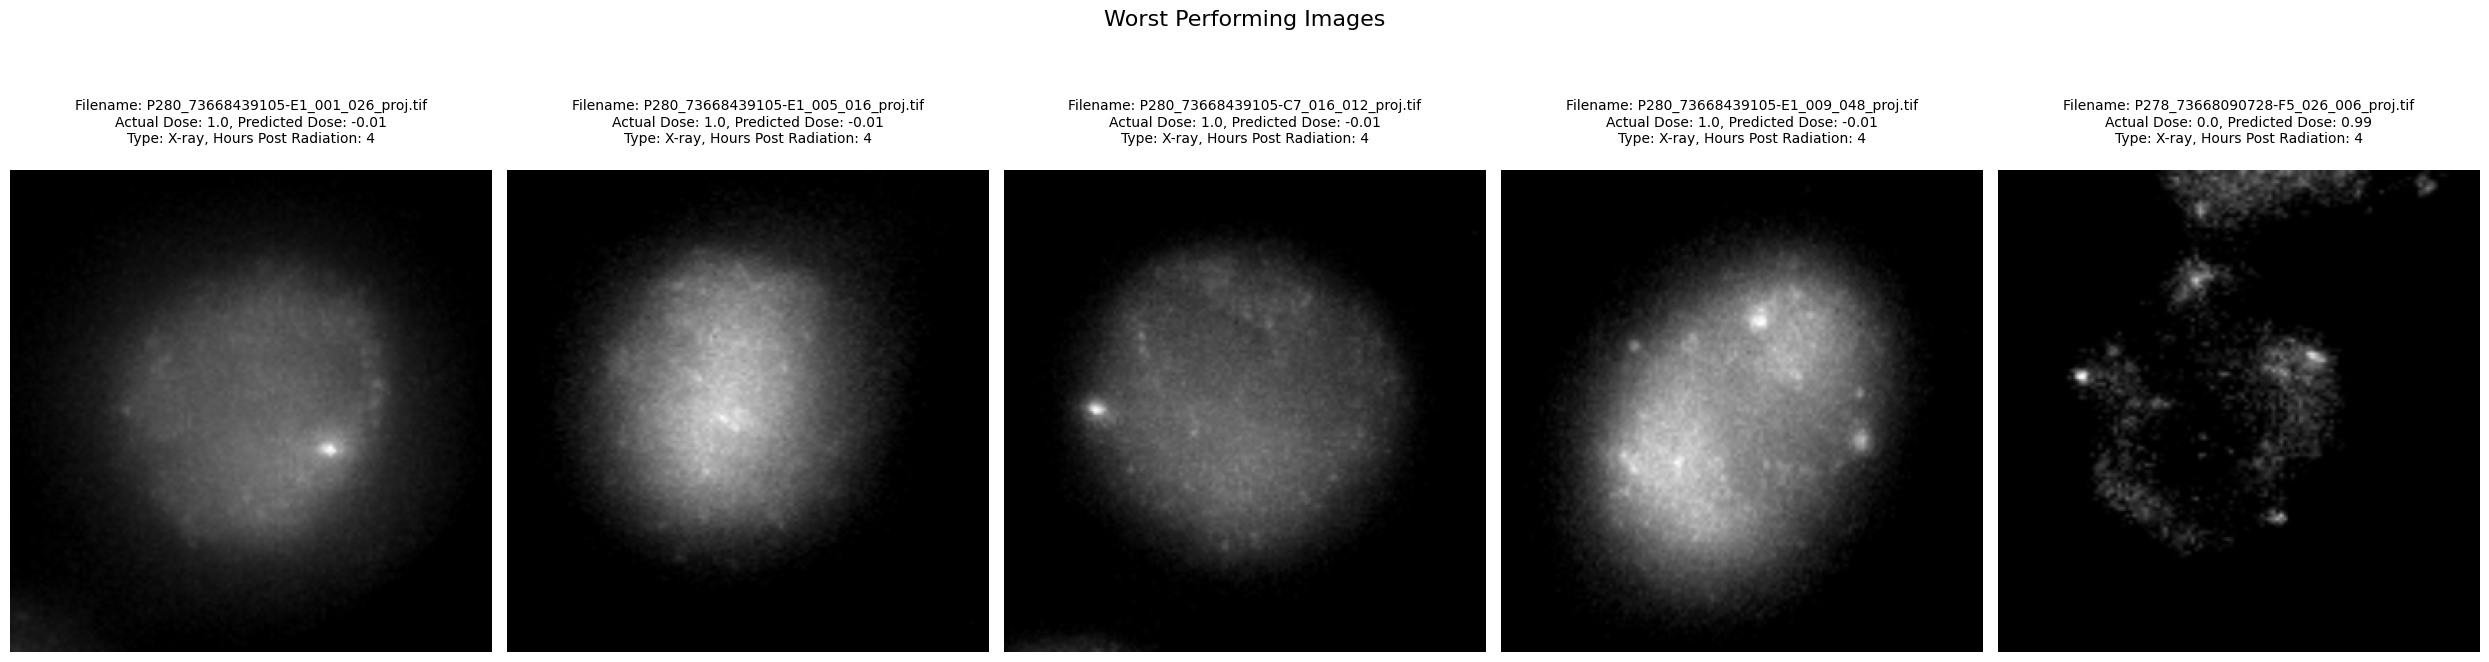

In [8]:
# Sort the data for best and worst performing images
best_performing = comparison_table.sort_values(by="Absolute Error", ascending=True).head(5)
worst_performing = comparison_table.sort_values(by="Absolute Error", ascending=False).head(5)

# Function to preprocess images (clip and normalize)
def preprocess_image(image_path, target_size=(256, 256)):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if image is None:
        raise ValueError(f"Could not load image: {image_path}")
    
    # Clip image values to [400, 4000]
    image = np.clip(image, 400, 4000)
    
    # Resize the image
    image = cv2.resize(image, target_size)
    
    # Normalize to [0, 1]
    image = (image - 400) / (4000 - 400)
    
    return image

# Function to load and display images with captions
def plot_images(data, title, metadata):
    fig, axes = plt.subplots(1, len(data), figsize=(25, 8))  # Increase figure width and height
    fig.suptitle(title, fontsize=16)

    for idx, (filename, actual, predicted, error) in enumerate(zip(data["Filename"], 
                                                                  data["Actual Dose"], 
                                                                  data["Predicted Dose"], 
                                                                  data["Absolute Error"])):
        # Preprocess image
        image = preprocess_image(filename)
        
        # Plot image
        axes[idx].imshow(image, cmap='gray')
        axes[idx].axis('off')
        
        # Fetch metadata for captions
        metadata_row = metadata[metadata["filepath"] == filename].iloc[0]
        caption = (
            f"Filename: {filename.split('/')[-1]}\n"
            f"Actual Dose: {actual}, Predicted Dose: {predicted:.2f}\n"
            f"Type: {metadata_row['particle_type']}, Hours Post Radiation: {metadata_row['hr_post_exposure']}"
        )
        axes[idx].set_title(caption, fontsize=10, pad=20)  # Add padding to separate the title from the plot

    plt.tight_layout()
    plt.show()


# Plot best-performing images
plot_images(best_performing, "Best Performing Images", test_metadata)

# Plot worst-performing images
plot_images(worst_performing, "Worst Performing Images", test_metadata)


In [9]:
mae_per_dose = {}
for dose in [0.0, 0.1, 1.0]:
    subset = comparison_table[comparison_table['Actual Dose'] == dose]
    mae = subset['Absolute Error'].mean()
    print(f"MAE for Dose {dose}: {mae}")
    mae_per_dose[f"MAE for Dose {dose}"] = mae

# Log all MAE values together
wandb.log(mae_per_dose)


MAE for Dose 0.0: 0.205253157668009
MAE for Dose 0.1: 0.27870295379862126
MAE for Dose 1.0: 0.12074876455527903


In [10]:
import seaborn as sns

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=comparison_table, x='Actual Dose', y='Absolute Error')
plt.title("Absolute Error Distribution by Dose")
plt.xlabel("Actual Dose")
plt.ylabel("Absolute Error")

# Save the plot as an image
plt.savefig("absolute_error_boxplot.png")

# Log the plot to W&B
wandb.log({"Absolute Error Boxplot": wandb.Image("absolute_error_boxplot.png")})

# Close the plot to free memory
plt.close()

# Finish the W&B run
wandb.finish()


MAE for Dose 0.0,▁
MAE for Dose 0.1,▁
MAE for Dose 1.0,▁
Max Absolute Error (Test),▁
R²,▁
Test Loss,▁▁
Test MAE,▁▁
Test MSE,▁
Test R²,▁
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [11]:
import pandas as pd
from sklearn.metrics import mean_absolute_error

# Example: Calculate MAE per dose
error_table = pd.DataFrame({"True Dose": y_val, "Predicted Dose": model.predict(X_val_subset).flatten()})
for dose in [0, 0.1, 1.0]:
    subset = error_table[error_table["True Dose"] == dose]
    mae = mean_absolute_error(subset["True Dose"], subset["Predicted Dose"])
    print(f"MAE for Dose {dose}: {mae}")


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAE for Dose 0: 0.22585828938050034
MAE for Dose 0.1: 0.286623546826246
MAE for Dose 1.0: 0.1238287979324392


In [12]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define test data (true values)
true_doses = y_test  # Actual values from the test set

# 1. Random Guessing
random_predictions = np.random.choice([0, 0.1, 1.0], size=len(true_doses))
random_mae = mean_absolute_error(true_doses, random_predictions)
random_mse = mean_squared_error(true_doses, random_predictions)
random_r2 = r2_score(true_doses, random_predictions)

# 2. Mean Prediction
mean_prediction = np.full_like(true_doses, y_train.mean())
mean_mae = mean_absolute_error(true_doses, mean_prediction)
mean_mse = mean_squared_error(true_doses, mean_prediction)
mean_r2 = r2_score(true_doses, mean_prediction)

# 3. Majority Prediction
majority_prediction = np.full_like(true_doses, np.bincount(y_train.astype(int)).argmax())
majority_mae = mean_absolute_error(true_doses, majority_prediction)
majority_mse = mean_squared_error(true_doses, majority_prediction)
majority_r2 = r2_score(true_doses, majority_prediction)

# 4. Model's Predictions
model_predictions = model.predict(X_test_subset).flatten()
model_mae = mean_absolute_error(true_doses, model_predictions)
model_mse = mean_squared_error(true_doses, model_predictions)
model_r2 = r2_score(true_doses, model_predictions)

# Print comparison
print("Performance Comparison:")
print(f"Random Guessing:    MAE={random_mae:.4f}, MSE={random_mse:.4f}, R²={random_r2:.4f}")
print(f"Mean Prediction:    MAE={mean_mae:.4f}, MSE={mean_mse:.4f}, R²={mean_r2:.4f}")
print(f"Majority Prediction:MAE={majority_mae:.4f}, MSE={majority_mse:.4f}, R²={majority_r2:.4f}")
print(f"Model Prediction:   MAE={model_mae:.4f}, MSE={model_mse:.4f}, R²={model_r2:.4f}")


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Performance Comparison:
Random Guessing:    MAE=0.4574, MSE=0.4158, R²=-1.0810
Mean Prediction:    MAE=0.4148, MSE=0.1998, R²=-0.0000
Majority Prediction:MAE=0.3536, MSE=0.3248, R²=-0.6257
Model Prediction:   MAE=0.2015, MSE=0.1526, R²=0.2363


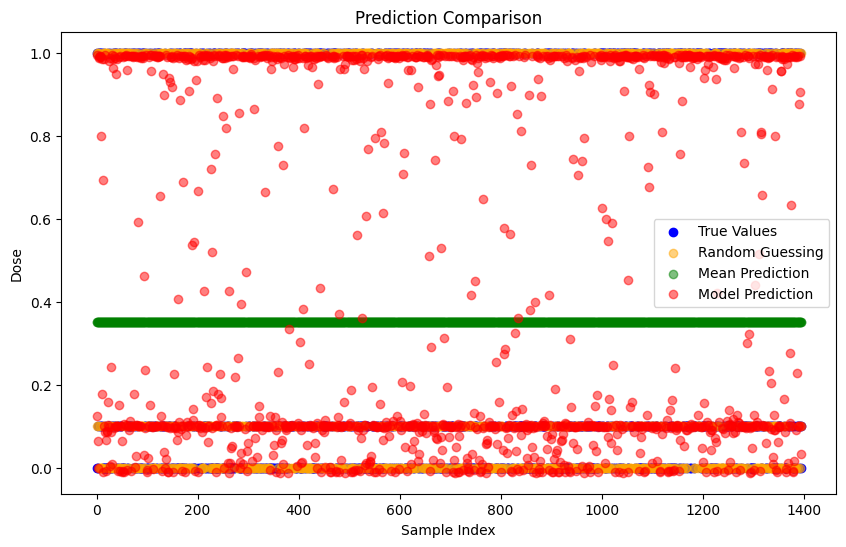

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(range(len(true_doses)), true_doses, label="True Values", color="blue")
plt.scatter(range(len(true_doses)), random_predictions, label="Random Guessing", color="orange", alpha=0.5)
plt.scatter(range(len(true_doses)), mean_prediction, label="Mean Prediction", color="green", alpha=0.5)
plt.scatter(range(len(true_doses)), model_predictions, label="Model Prediction", color="red", alpha=0.5)
plt.xlabel("Sample Index")
plt.ylabel("Dose")
plt.legend()
plt.title("Prediction Comparison")
plt.show()


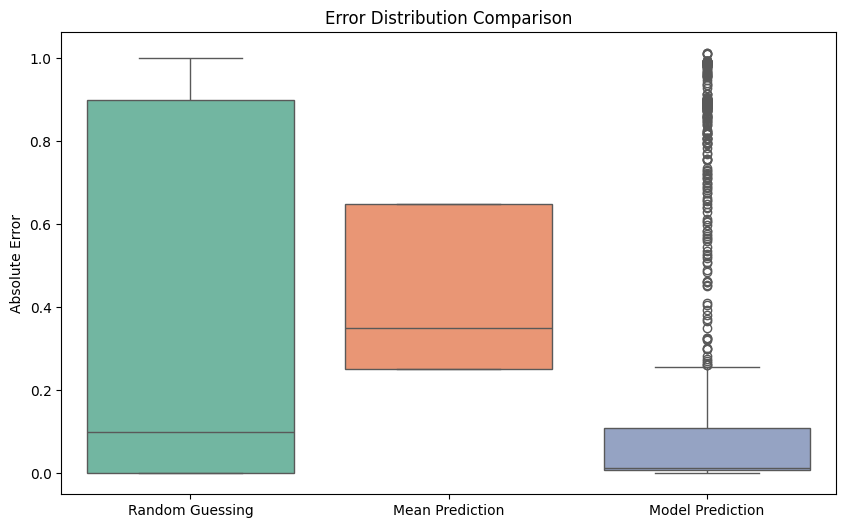

In [14]:
import seaborn as sns

errors = {
    "Random Guessing": np.abs(true_doses - random_predictions),
    "Mean Prediction": np.abs(true_doses - mean_prediction),
    "Model Prediction": np.abs(true_doses - model_predictions),
}

plt.figure(figsize=(10, 6))
sns.boxplot(data=list(errors.values()), palette="Set2")
plt.xticks(ticks=range(len(errors)), labels=errors.keys())
plt.title("Error Distribution Comparison")
plt.ylabel("Absolute Error")
plt.show()


In [15]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Use a subset of your training data for the SHAP explainer
explainer = shap.Explainer(model, X_train_subset)

# Calculate SHAP values for the test set
shap_values = explainer(X_test_subset)


/home/walt/FociNet/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
ExactExplainer explainer: 1397it [00:11, 16.95it/s]                           


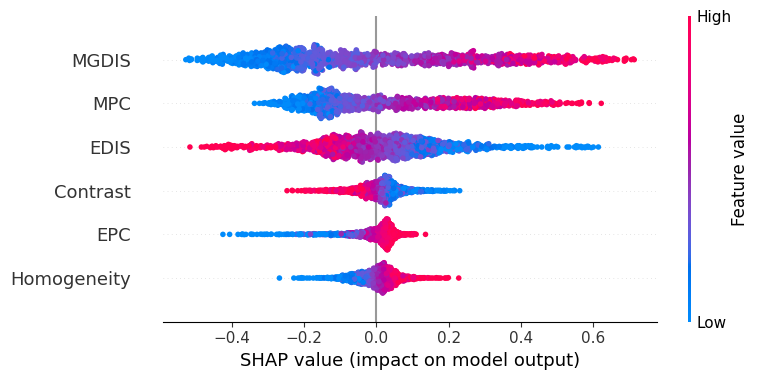

In [16]:
# Summary plot to visualize global feature importance
shap.summary_plot(shap_values, X_test_subset, feature_names=["MPC", "EPC", "EDIS", "MGDIS", "Contrast", "Homogeneity", "Sharpness"])


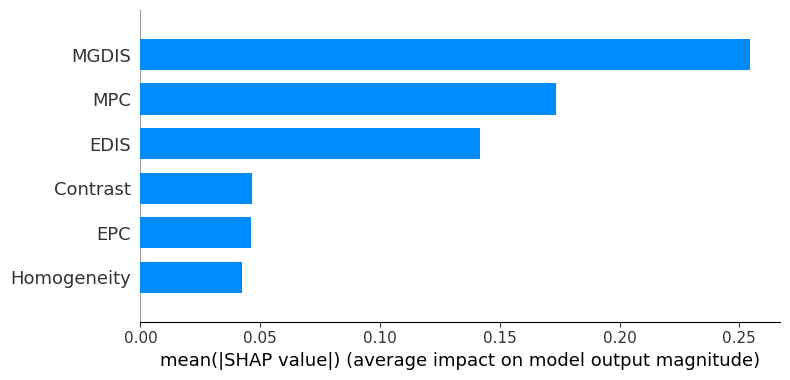

In [17]:
# Bar plot for global feature importance
shap.summary_plot(shap_values, X_test_subset, plot_type="bar", feature_names=["MPC", "EPC", "EDIS", "MGDIS", "Contrast", "Homogeneity", "Sharpness"])


In [18]:
import shap
shap.initjs()


# Dynamically derive feature names based on the active feature flags in the config
feature_names = []
if config.get("include_mpc", True):
    feature_names.extend(["MPC", "EPC"])
if config.get("include_edis", True):
    feature_names.append("EDIS")
if config.get("include_mgdis", True):
    feature_names.append("MGDIS")
if config.get("include_texture", True):
    feature_names.extend(["Contrast", "Homogeneity"])
if config.get("include_sharpness", True):
    feature_names.append("Sharpness")


# Force plot for a single prediction (e.g., the first test sample)
shap.force_plot(
    shap_values.base_values[0],  # Use base_values from shap_values
    shap_values.values[0],       # Use values from shap_values
    X_test_subset[0],            # Input sample
    feature_names=feature_names  # Dynamically derived feature names
)


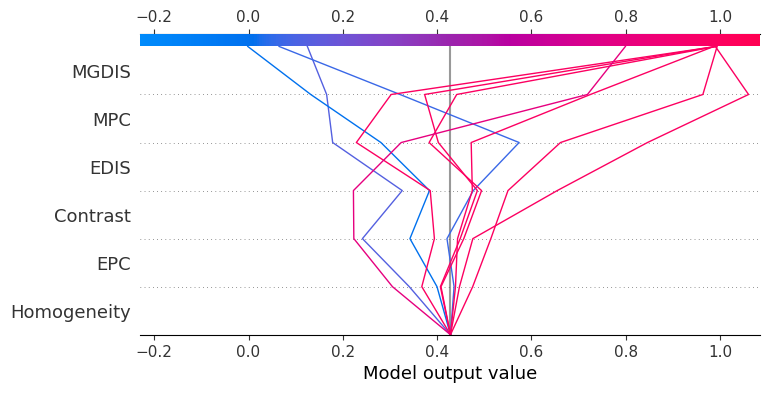

In [19]:
# Ensure feature names align with the subset shape
feature_names = ["MPC", "EPC", "EDIS", "MGDIS", "Contrast", "Homogeneity", "Sharpness"][:X_test_subset.shape[1]]

# Generate the decision plot
shap.decision_plot(
    base_value=shap_values.base_values[0], 
    shap_values=shap_values.values[:10], 
    features=X_test_subset[:10], 
    feature_names=feature_names
)


In [20]:
# Save the model in a directory
# model.save("xray_radiation_model.keras")

print("Model saved successfully!")


Model saved successfully!


In [21]:
# Add a column for Absolute Error
comparison_table["Absolute Error"] = abs(comparison_table["Actual Dose"] - comparison_table["Predicted Dose"])

# Function to get top N predictions for a specific actual dose
def get_top_predictions(comparison_table, actual_dose, top_n=3):
    filtered_table = comparison_table[comparison_table["Actual Dose"] == actual_dose]
    sorted_table = filtered_table.sort_values(by="Absolute Error", ascending=True)
    return sorted_table.head(top_n)[["Filename", "Actual Dose", "Predicted Dose", "Absolute Error"]]

# Get top 3 predictions for each dose
top_3_for_1_0 = get_top_predictions(comparison_table, 1.0, top_n=3)
top_3_for_0_1 = get_top_predictions(comparison_table, 0.1, top_n=3)
top_3_for_0_0 = get_top_predictions(comparison_table, 0.0, top_n=3)

# Print the results
print("Top 3 predictions for 1.0 Gy:")
print(top_3_for_1_0)

print("\nTop 3 predictions for 0.1 Gy:")
print(top_3_for_0_1)

print("\nTop 3 predictions for 0.0 Gy:")
print(top_3_for_0_0)

# Log the results to W&B
# wandb.log({
#     "Top 3 Predictions for 1.0 Gy": wandb.Table(dataframe=top_3_for_1_0),
#     "Top 3 Predictions for 0.1 Gy": wandb.Table(dataframe=top_3_for_0_1),
#     "Top 3 Predictions for 0.0 Gy": wandb.Table(dataframe=top_3_for_0_0),
# })


Top 3 predictions for 1.0 Gy:
                                               Filename  Actual Dose  \
305   BPS-Microscopy/train/P280_73668439105-E1_008_0...          1.0   
1047  BPS-Microscopy/train/P280_73668439105-D5_008_0...          1.0   
654   BPS-Microscopy/train/P280_73668439105-A7_018_0...          1.0   

      Predicted Dose  Absolute Error  
305         0.996742        0.003258  
1047        0.995511        0.004489  
654         0.995460        0.004540  

Top 3 predictions for 0.1 Gy:
                                               Filename  Actual Dose  \
1059  BPS-Microscopy/train/P279_73668277350-C7_035_0...          0.1   
181   BPS-Microscopy/train/P279_73668277350-F5_018_0...          0.1   
1259  BPS-Microscopy/train/P279_73668277350-E6_017_0...          0.1   

      Predicted Dose  Absolute Error  
1059        0.100014        0.000014  
181         0.100023        0.000023  
1259        0.099977        0.000023  

Top 3 predictions for 0.0 Gy:
                  

In [22]:
import os
import shutil

# Define the directory to save the copied images
output_directory = "best_predictions_images"
os.makedirs(output_directory, exist_ok=True)

# Function to save file locations and copy images
def save_and_copy_images(top_predictions, label, output_dir):
    # Save the file paths to a text file
    file_path = os.path.join(output_dir, f"top_predictions_{label}.txt")
    with open(file_path, "w") as f:
        for _, row in top_predictions.iterrows():
            f.write(row["Filename"] + "\n")

    # Copy the images to the output directory
    label_dir = os.path.join(output_dir, label)
    os.makedirs(label_dir, exist_ok=True)
    for _, row in top_predictions.iterrows():
        source = row["Filename"]
        destination = os.path.join(label_dir, os.path.basename(source))
        shutil.copy(source, destination)

    print(f"Saved file paths to {file_path} and copied images to {label_dir}")

# Save and copy images for each dose
save_and_copy_images(top_3_for_1_0, "1.0_Gy", output_directory)
save_and_copy_images(top_3_for_0_1, "0.1_Gy", output_directory)
save_and_copy_images(top_3_for_0_0, "0.0_Gy", output_directory)


Saved file paths to best_predictions_images/top_predictions_1.0_Gy.txt and copied images to best_predictions_images/1.0_Gy
Saved file paths to best_predictions_images/top_predictions_0.1_Gy.txt and copied images to best_predictions_images/0.1_Gy
Saved file paths to best_predictions_images/top_predictions_0.0_Gy.txt and copied images to best_predictions_images/0.0_Gy


Visualizing predictions for 1.0 Gy:


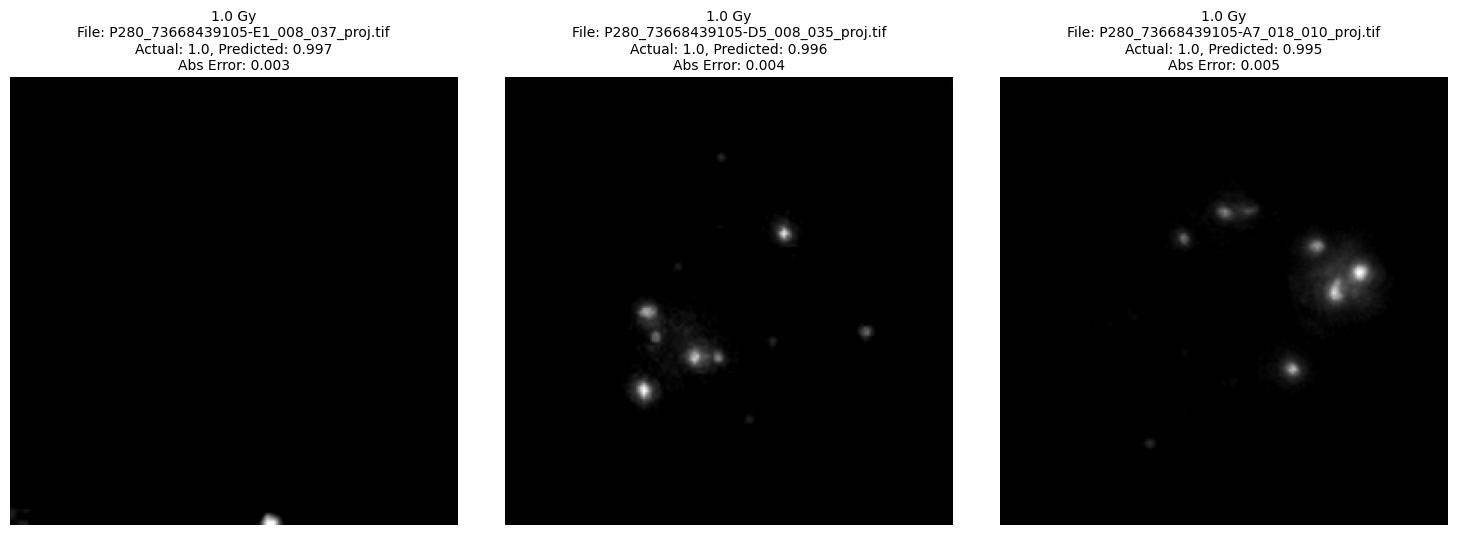

Visualizing predictions for 0.1 Gy:


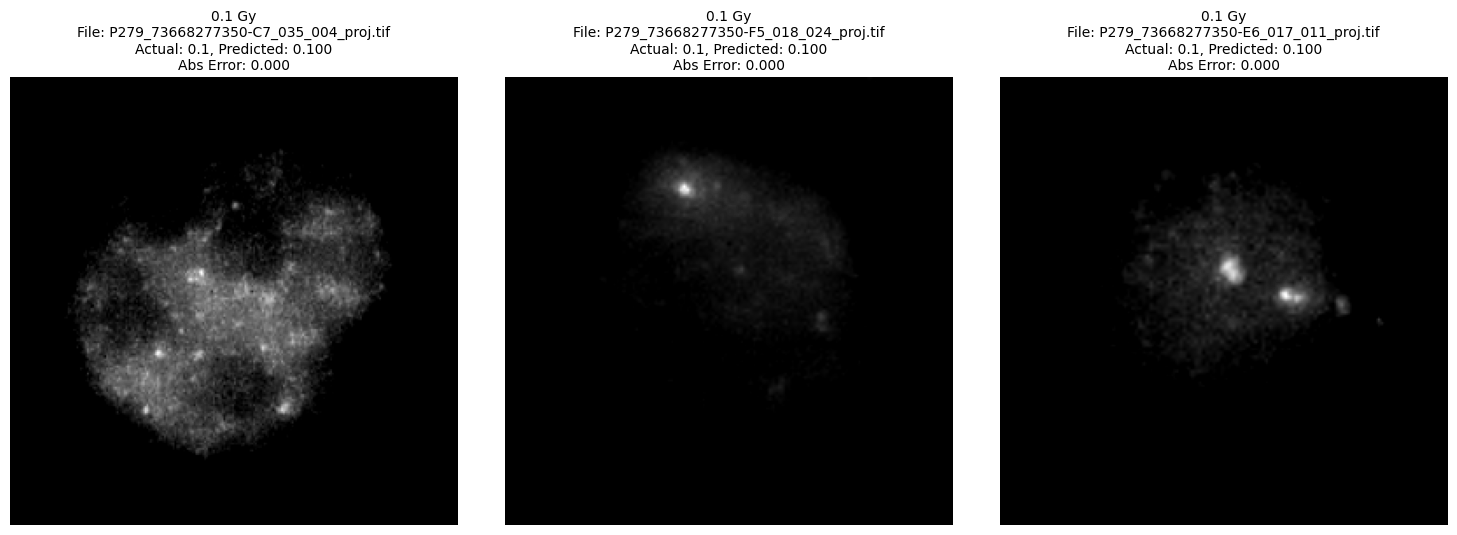

Visualizing predictions for 0.0 Gy:


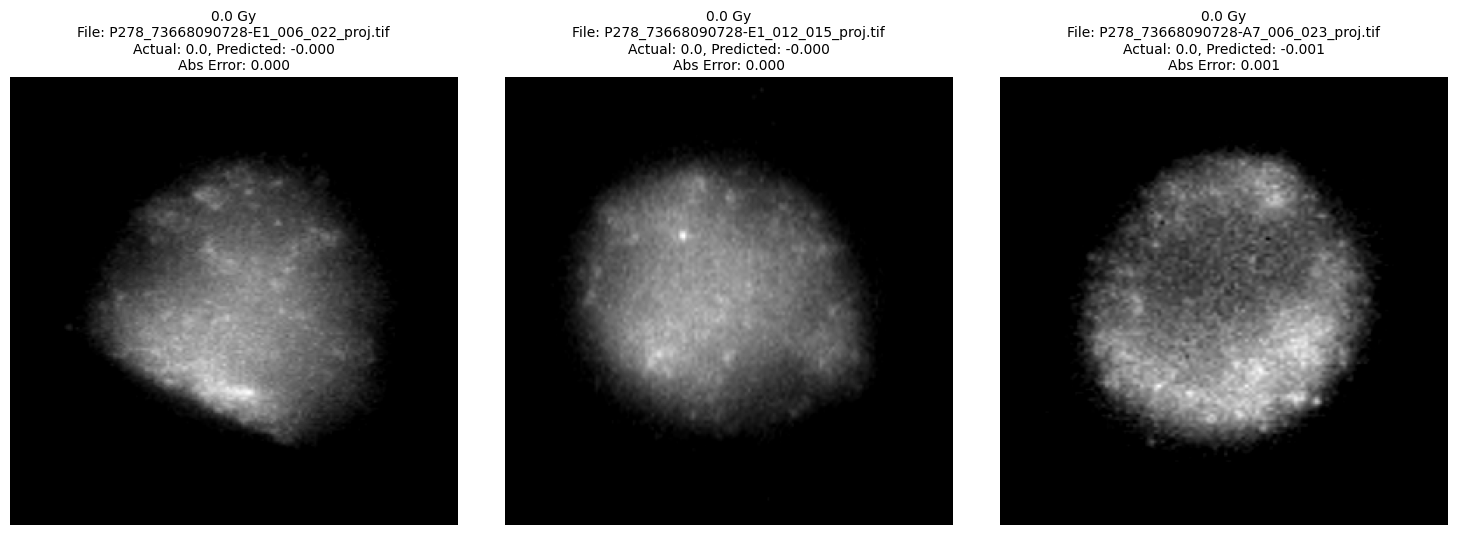

In [25]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Modified function to visualize top predictions
def visualize_predictions(top_predictions, label, target_size=(256, 256)):
    """
    Visualizes predictions by displaying the images alongside their predictions and errors.

    Parameters:
    - top_predictions: DataFrame containing top predictions.
    - label: Label to show on the plot.
    - target_size: Tuple for resizing the image.
    """
    num_images = len(top_predictions)
    plt.figure(figsize=(15, 5 * (num_images // 3 + 1)))

    for i, (_, row) in enumerate(top_predictions.iterrows()):
        try:
            # Use load_image_opencv to preprocess the image
            image_path = tf.constant(row["Filename"])
            image = load_image_opencv(image_path, target_size=target_size)

            # Create a subplot for each image
            plt.subplot(num_images // 3 + 1, 3, i + 1)
            plt.imshow(image[..., 0], cmap="gray")  # Use grayscale channel
            plt.title(
                f"{label}\n"
                f"File: {row['Filename'].split('/')[-1]}\n"  # Only show the file name
                f"Actual: {row['Actual Dose']}, Predicted: {row['Predicted Dose']:.3f}\n"
                f"Abs Error: {row['Absolute Error']:.3f}",
                fontsize=10
            )
            plt.axis("off")
        except Exception as e:
            print(f"Error loading image {row['Filename']}: {e}")

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Visualize predictions for each dose
print("Visualizing predictions for 1.0 Gy:")
visualize_predictions(top_3_for_1_0, "1.0 Gy")

print("Visualizing predictions for 0.1 Gy:")
visualize_predictions(top_3_for_0_1, "0.1 Gy")

print("Visualizing predictions for 0.0 Gy:")
visualize_predictions(top_3_for_0_0, "0.0 Gy")
